In [8]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def read_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    # If the image is multi-component (e.g., RGB), convert it to grayscale
    if image.GetNumberOfComponentsPerPixel() > 1:
        channels = [sitk.VectorIndexSelectionCast(image, i) for i in range(image.GetNumberOfComponentsPerPixel())]
        image = sum(channels) / len(channels)

    image = sitk.Cast(image, sitk.sitkFloat32)

    return image

# Update the paths to the directories containing your DICOM series
CTA_directory = r'D:\CTH_archive\PN1'
tmax_map_directory = r'D:\CTH_archive\TEST_TMAX'
CTH_directory = r'D:\CTH_archive\CTH_DICOM_SINGLE_FILES'

CTA_image = read_dicom_series(CTA_directory)
tmax_map_image = read_dicom_series(tmax_map_directory)
CTH_image = read_dicom_series(CTH_directory)

In [14]:
import SimpleITK as sitk

# Save the CTH_image as a NIfTI file
nifti_filename = r'D:\CTH_archive\TCTH_image.nii'
sitk.WriteImage(CTH_image, nifti_filename)


In [9]:
def show_image(volume, title="Image", slice_index=None):
    if slice_index is None:
        # If no specific slice is requested, default to the middle slice in the first dimension
        slice_index = volume.shape[0] // 2

    # Extract the 2D slice from the 3D volume
    slice_2d = volume[slice_index, :, :]

    plt.figure(figsize=(10, 10))
    plt.title(f"{title} - Slice {slice_index}")
    plt.imshow(slice_2d, cmap="gray")
    plt.axis('off')  # Remove axes ticks
    plt.show()

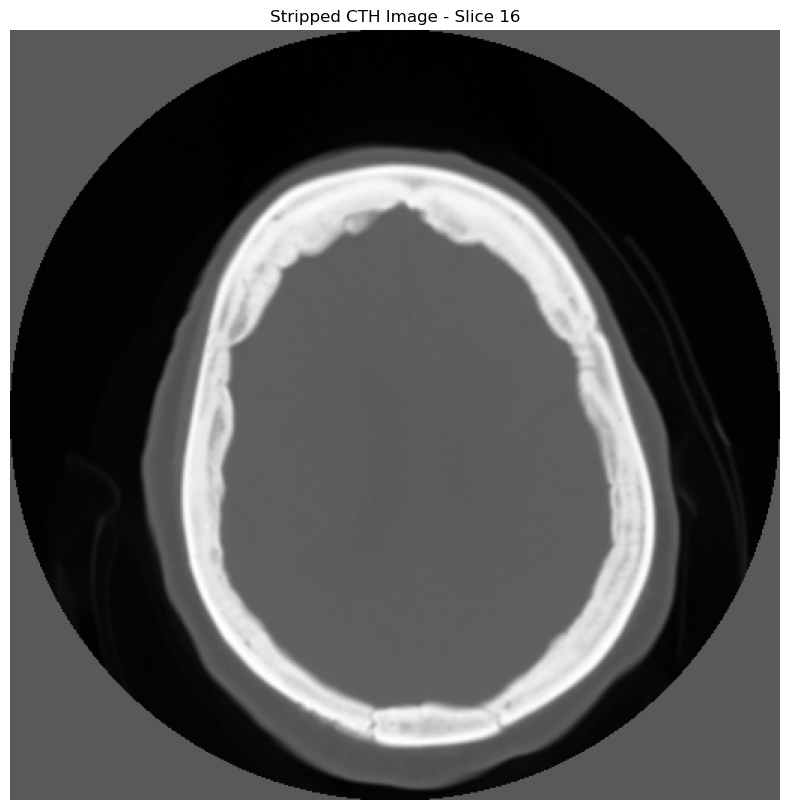

In [11]:
def segment_brain(image):
    # Step 1: Thresholding to isolate the brain and other high-intensity structures
    # You might need to adjust the threshold value based on your specific images
    brain_threshold = image > 100  # Example threshold value; adjust based on your image's intensity range
    
    # Step 2: Morphological closing to fill gaps in the thresholded image
    closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
    closing_filter.SetKernelRadius(5)  # Example radius; adjust as needed
    closing_filter.SetForegroundValue(1)
    closed_brain = closing_filter.Execute(brain_threshold)
    
    # Step 3: Remove small objects that are not the brain (e.g., eyes)
    connected_component = sitk.ConnectedComponent(closed_brain)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(connected_component, closed_brain)
    
    # Assuming the largest connected component is the brain
    largest_label = max(stats.GetLabels(), key=lambda l: stats.GetPhysicalSize(l))
    brain_segmentation = sitk.Equal(connected_component, largest_label)
    
    # Step 4: Apply the segmentation mask to the original image
    segmented_brain = sitk.Mask(image, brain_segmentation)
    
    return segmented_brain

# Segment the brain from the CTH image
segmented_brain_image = segment_brain(CTH_image)


# Now visualize the 2D slice using the modified function
show_image(CTH_stripped_array, "Stripped CTH Image")


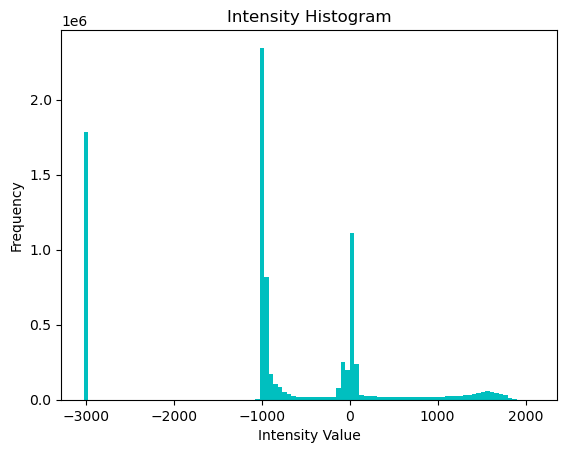

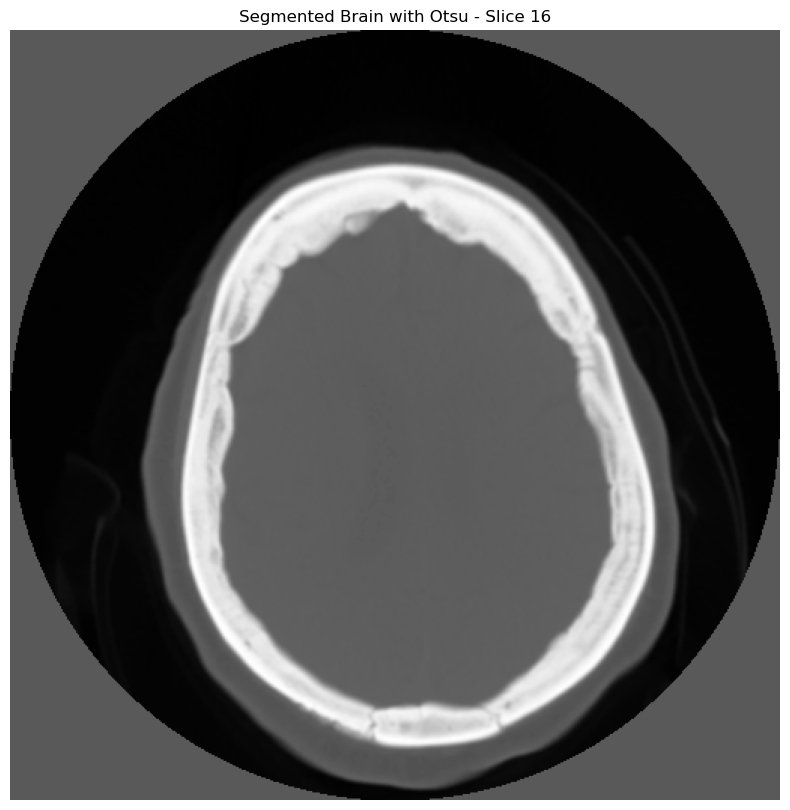

In [12]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

def inspect_histogram(image):
    # Convert the image to a NumPy array
    array = sitk.GetArrayFromImage(image)
    
    # Plot the histogram
    plt.hist(array.flatten(), bins=100, color='c')
    plt.title('Intensity Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.show()

def segment_brain_otsu(image):
    # Apply Otsu's thresholding method to separate brain from non-brain tissue
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    brain_mask = otsu_filter.Execute(image)
    
    # Apply the mask to the original image
    segmented_brain = sitk.Mask(image, brain_mask)
    
    return segmented_brain

# First, inspect the histogram to decide on thresholding approach
inspect_histogram(CTH_image)

# Then, try segmenting with Otsu's method
segmented_brain_otsu = segment_brain_otsu(CTH_image)

# Visualize the segmented brain (assuming you have a show_image function defined)
show_image(sitk.GetArrayFromImage(segmented_brain_otsu), "Segmented Brain with Otsu")


In [17]:
show_image(sitk.ReadImage('D:\CTH_archive\CTH_image_strip.nii'), "Stripped CTH Image")

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "D:\CTH_archive\CTH_image_strip.nii" does not exist.